This code is to initialize the pretrained VGG16 model with ImageNet weights and retrain the model from end to end on the current task of detecting Pneumonia and further differentiate Bacterial and Viral Pneumonia types. 

In [1]:
from __future__ import print_function

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import numpy as np
import time
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
#from evaluation import plot_confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
%matplotlib inline

In [13]:
# Loading the data
train_data_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/train'
test_data_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/test'
img_width = 128
img_height = 128
channel = 3
input_img = Input(shape = (img_width, img_height, channel))
epochs = 20
batch_size = 10 #vary this parameter depending on your GPU capacity
num_classes= 2 #[pneumonia, normal] [bacterial, viral]

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

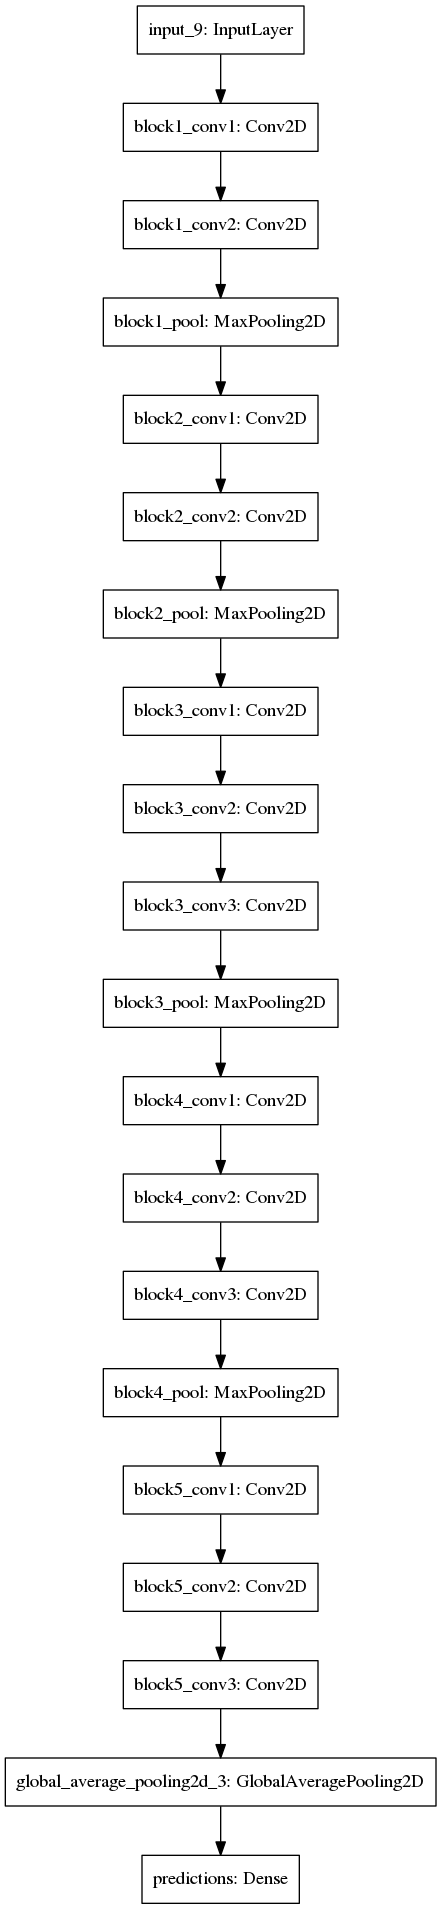

In [14]:
#define the VGG16 and customize
feature_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width,img_height,channel))
feature_model=Model(inputs=feature_model.input,outputs=feature_model.get_layer('block5_conv3').output)

#addind the top layers
x = feature_model.output
x = GlobalAveragePooling2D()(x) 
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
model = Model(inputs=feature_model.input, outputs=predictions)
model.summary()

#plot the model
plot_model(model, to_file='custom_VGG16_model.png')

We performed five-fold cross validation in this study. We have however shown running the script with a sample data fold. We performed no augmentation other than rescaling.We allocated 20% of the training data at random for validation.

In [15]:
#declaring image data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   shear_range=0.2,
                                   zoom_range=0.2, validation_split=0.2) #taking 20% of training for validation 

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(128,128),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(128,128),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(128,128),
        batch_size=batch_size,
        class_mode='categorical',shuffle=False)

#count the number of samples
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

#check the class indices
train_generator.class_indices
validation_generator.class_indices
test_generator.class_indices

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


{'NORMAL': 0, 'PNEUMONIA': 1}

Allocate balanced weights to penalize over-represented classes

In [ ]:
"""from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)
print(class_weights)"""

In [10]:
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)

callbacks = [reduce_learning_rate]

In [16]:
#fix the optimizer
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True) #optimize to your requirements

#compile the model
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#compute the training time
#start = time.time()

#give the path to store the model weights
#filepath = 'weights/' + model.name + '.{epoch:02d}-{val_acc:.4f}.hdf5'

#save only the best weights
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_weights_only=True, save_best_only=True, mode='max', period=1)

#visualize model performance using TensorBoard
#tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=batch_size)
#callbacks_list = [checkpoint, tensor_board]

#train model
custom_vgg16_history = model.fit_generator(
      train_generator,
      steps_per_epoch=nb_train_samples // batch_size, 
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_validation_samples // batch_size, 
      verbose=1)

#print the total time taken for training
#print(time.time()-start)

Train for 417 steps, validate for 104 steps
Epoch 1/20
417/417 [==============================] - 86s 206ms/step - loss: 0.2607 - accuracy: 0.8845 - val_loss: 0.1910 - val_accuracy: 0.9115
Epoch 2/20
417/417 [==============================] - 84s 200ms/step - loss: 0.1620 - accuracy: 0.9359 - val_loss: 0.1923 - val_accuracy: 0.9202
Epoch 3/20
417/417 [==============================] - 85s 203ms/step - loss: 0.1289 - accuracy: 0.9488 - val_loss: 0.1078 - val_accuracy: 0.9558
Epoch 4/20
417/417 [==============================] - 84s 201ms/step - loss: 0.1104 - accuracy: 0.9584 - val_loss: 0.1228 - val_accuracy: 0.9587
Epoch 5/20
417/417 [==============================] - 84s 202ms/step - loss: 0.0989 - accuracy: 0.9628 - val_loss: 0.1277 - val_accuracy: 0.9490
Epoch 6/20
417/417 [==============================] - 84s 201ms/step - loss: 0.0957 - accuracy: 0.9642 - val_loss: 0.1384 - val_accuracy: 0.9423
Epoch 7/20
417/417 [==============================] - 83s 200ms/step - loss: 0.0860 - 

In [17]:
#Testing the model's performance by loading the model weights

#model.load_weights('weights/weights-improvement-39-0.9615.hdf5') #change this to your path and model weights
custom_vgg16_y_pred = model.predict_generator(test_generator, nb_test_samples/batch_size, workers=1)

#true labels
Y_test=test_generator.classes

#print the shape of y_pred and Y_test
print(custom_vgg16_y_pred.shape)
print(Y_test.shape)

#measure accuracy
custom_vgg16_model_accuracy=accuracy_score(Y_test,custom_vgg16_y_pred.argmax(axis=-1))
print('The accuracy of custom VGG16 model is: ', custom_vgg16_model_accuracy)

(624, 2)
(624,)
The accuracy of custom VGG16 model is:  0.9214743589743589


In [19]:
acc = custom_vgg16_history.history['accuracy']
val_acc = custom_vgg16_history.history['val_accuracy']
loss = custom_vgg16_history.history['loss']
val_loss = custom_vgg16_history.history['val_loss']

In [20]:
acc = [0] + acc
val_acc = [0] + val_acc
loss = [1] + loss
val_loss = [1] + val_loss

In [24]:
len(loss)

21

In [25]:
num_epochs = np.arange(0,21)

In [26]:
num_epochs

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [27]:
acc

[0,
 0.8844583,
 0.93586355,
 0.94883496,
 0.9584434,
 0.96276724,
 0.9642085,
 0.9682921,
 0.97093445,
 0.9716551,
 0.97117466,
 0.9735767,
 0.97645926,
 0.9747778,
 0.9791016,
 0.978381,
 0.97742015,
 0.9807831,
 0.98294497,
 0.9812635,
 0.98294497]

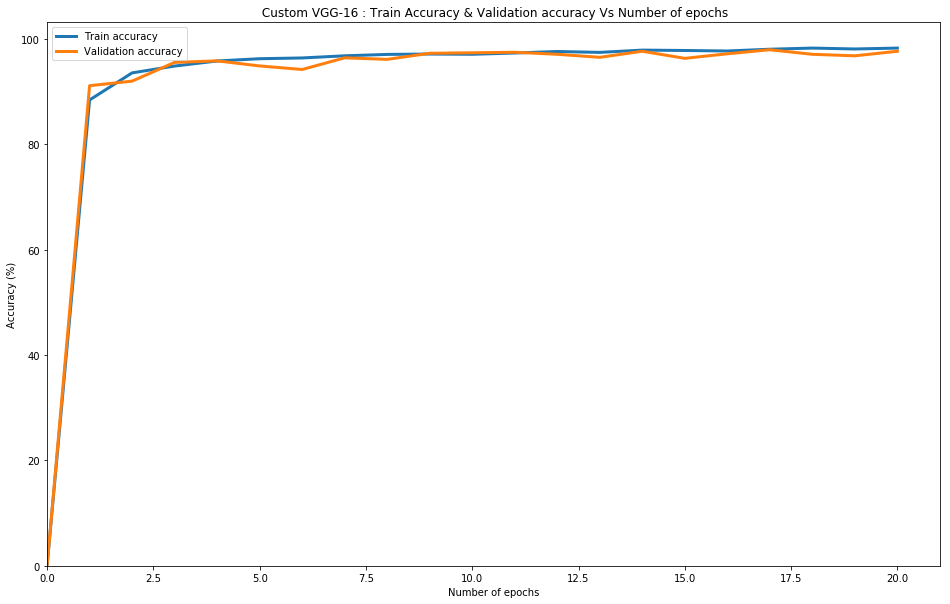

In [29]:
plt.figure(figsize=(16,10)) # we give the shape of the figure
plt.plot(num_epochs, np.dot(acc, 100), label = 'Train accuracy', linewidth=3) # plot the graph (ranks, frequency) of the corpus Gutenberg with stopwords
plt.plot(num_epochs, np.dot(val_acc,100), label = 'Validation accuracy', linewidth=3) # plot the graph (ranks, frequency) of the corpus Gutenberg without stopwords
plt.ylim(ymin=0)
plt.xlabel('Number of epochs') # We give a label to our x Axis
plt.ylabel('Accuracy (%)') # We give a label to our y Axis
plt.title(" Custom VGG-16 : Train Accuracy & Validation accuracy Vs Number of epochs") # Give a title to the figure plt.xscale('log') # we use a logarithmic scale for the x axis
plt.xlim(xmin = 0) # we set the x axe to begin from 1
plt.legend() # make a legend for each curves
plt.show() # Show the result
###End

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


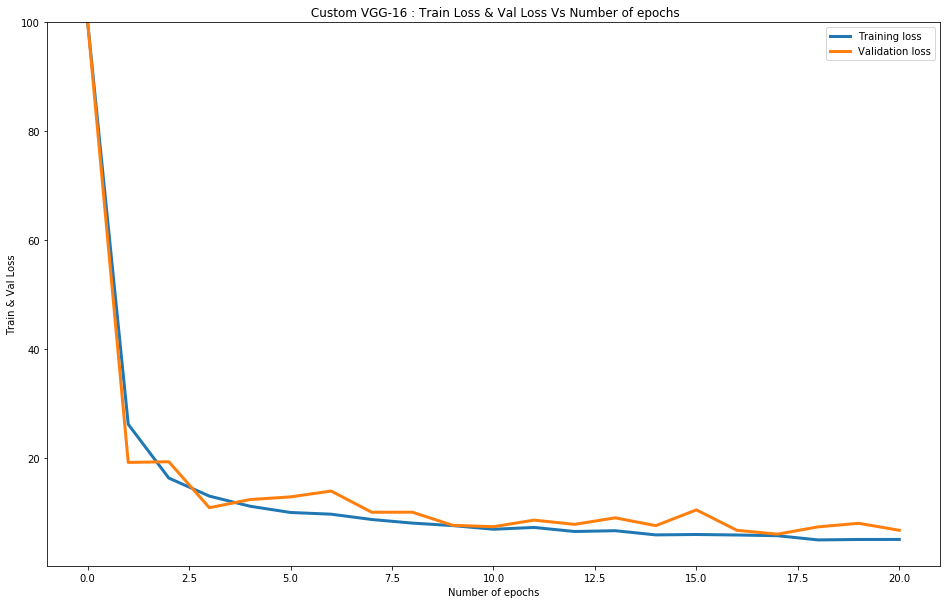

In [30]:
plt.figure(figsize=(16,10)) # we give the shape of the figure
plt.plot(num_epochs, np.dot(loss, 100), label = 'Training loss', linewidth=3) # plot the graph (ranks, frequency) of the corpus Gutenberg with stopwords
plt.plot(num_epochs, np.dot(val_loss, 100), label = 'Validation loss', linewidth=3) # plot the graph (ranks, frequency) of the corpus Gutenberg with stopwords
plt.ylim(ymax=100)
plt.xlabel('Number of epochs') # We give a label to our x Axis
plt.ylabel('Train & Val Loss') # We give a label to our y Axis
plt.title(" Custom VGG-16 : Train Loss & Val Loss Vs Number of epochs") # Give a title to the figure plt.xscale('log') # we use a logarithmic scale for the x axis
plt.legend() # make a legend for each curves
plt.show() # Show the result
###End

In [32]:
train_generator.index_array

array([ 778, 1156, 1851, ..., 3139, 3715, 1744])

In [33]:
train_generator.reset()
train_pred = model.predict_generator(train_generator)
train_pred = train_pred.argmax(axis=-1)
train_classes = train_generator.classes[train_generator.index_array]

In [36]:
train_pred = train_pred.argmax(axis=-1)

In [38]:
validation_generator.reset()
val_pred = model.predict_generator(validation_generator)
val_pred = val_pred.argmax(axis=-1)
val_classes = validation_generator.classes[validation_generator.index_array]

In [40]:
val_pred

array([0, 1, 0, ..., 0, 1, 1])

In [41]:
test_generator.reset()
test_pred = model.predict_generator(test_generator)
test_pred = test_pred.argmax(axis=-1)
test_classes = test_generator.classes[test_generator.index_array]

In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [43]:
print('the classification report for the training dataset is : ')
print(classification_report(train_classes, train_pred))

the classification report for the training dataset is : 
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1073
           1       0.99      0.99      0.99      3100

    accuracy                           0.99      4173
   macro avg       0.99      0.98      0.98      4173
weighted avg       0.99      0.99      0.99      4173



In [44]:
print('the classification report for the validation dataset is : ')
print(classification_report(val_classes, val_pred))

the classification report for the validation dataset is : 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       268
           1       0.98      0.98      0.98       775

    accuracy                           0.98      1043
   macro avg       0.97      0.97      0.97      1043
weighted avg       0.98      0.98      0.98      1043



In [45]:
print('the classification report for the test dataset is : ')
print(classification_report(test_classes, test_pred))

the classification report for the test dataset is : 
              precision    recall  f1-score   support

           0       0.98      0.81      0.89       234
           1       0.90      0.99      0.94       390

    accuracy                           0.92       624
   macro avg       0.94      0.90      0.91       624
weighted avg       0.93      0.92      0.92       624



In [46]:
import scikitplot as skplt

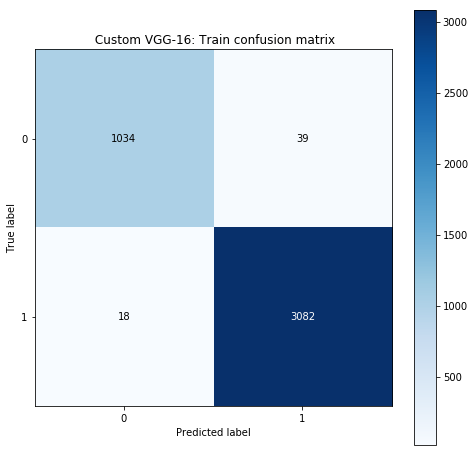

In [49]:
skplt.metrics.plot_confusion_matrix(train_classes, train_pred, figsize=(8,8))
plt.title(" Custom VGG-16: Train confusion matrix")
plt.show()

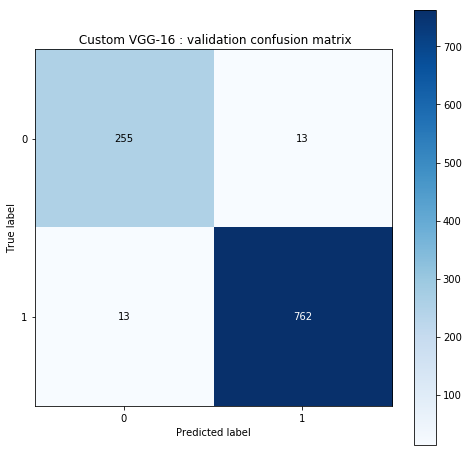

In [50]:
skplt.metrics.plot_confusion_matrix(val_classes, val_pred, figsize=(8,8))
plt.title(" Custom VGG-16 : validation confusion matrix")
plt.show()

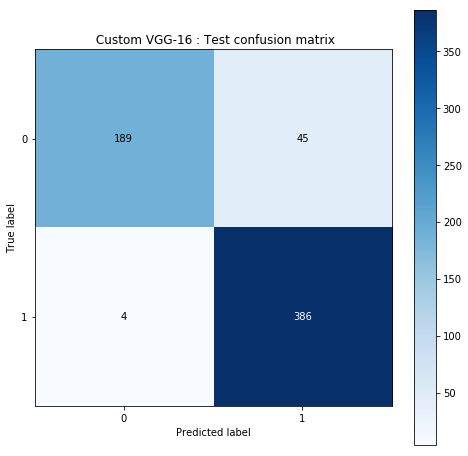

In [51]:
skplt.metrics.plot_confusion_matrix(test_classes, test_pred, figsize=(8,8))
plt.title(" Custom VGG-16 : Test confusion matrix")
plt.show()

In [54]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [57]:
print("the number of the model parameters is : " + str(model.count_params()))

the number of the model parameters is : 14715714


In [ ]:
model.save("custom_vgg16.h5")

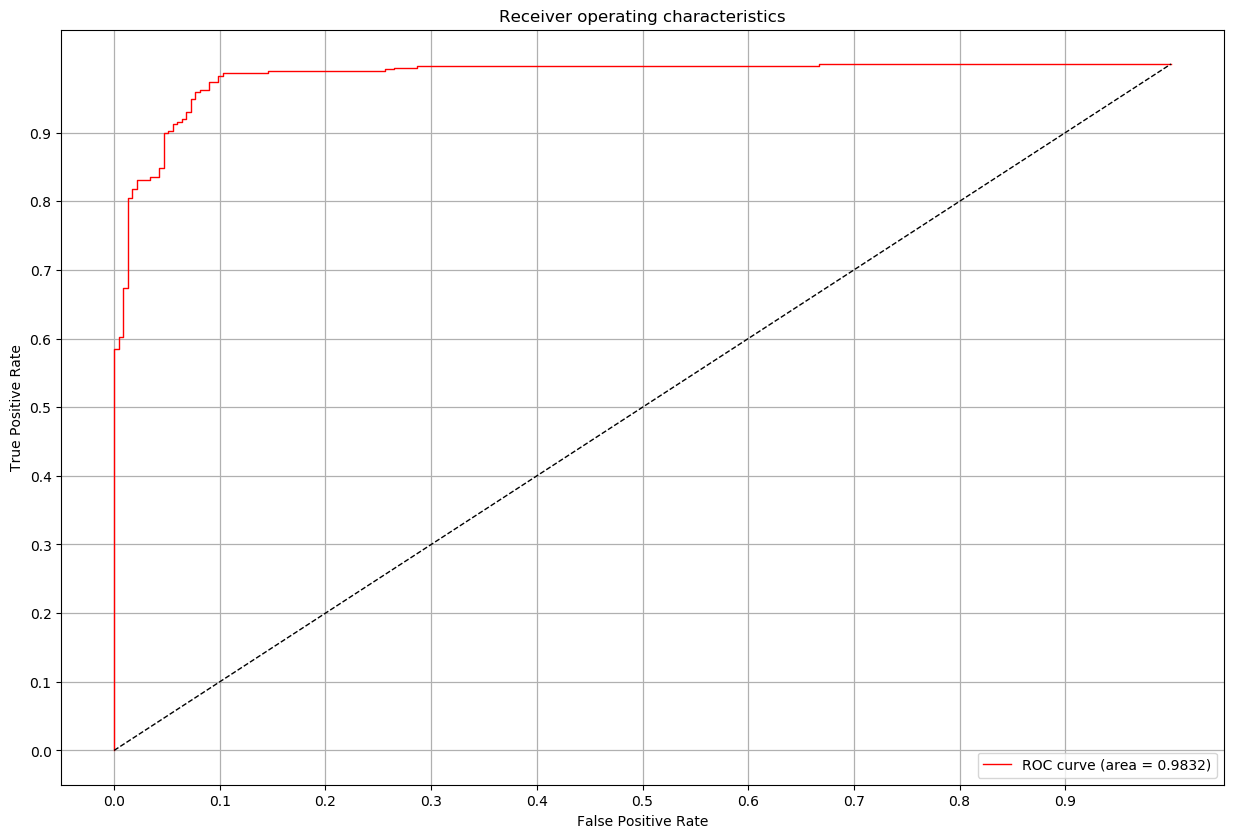

In [53]:
#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, custom_vgg16_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.10)
minor_ticks = np.arange(0.0, 1.0, 0.10)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()